In [1]:
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
import json
import pickle
import librosa
import os
import soundfile as sf
from IPython.display import Audio, display
plt.style.use('default')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
data_folder = r'/content/drive/MyDrive/'

# Speech Denoising using RNN

In [4]:
#load data
def load_speech_data(speech_folder,data_type):
  #sort all the files
  file_list = os.listdir(speech_folder)
  file_list.sort()

  #define X, S and N
  X,S,N = [],[],[]

  for file in file_list:
    file_path = os.path.join(speech_folder,file)
    # audio,sr = librosa.load(file_path,sr=None)
    # spectogram = librosa.stft(audio,n_fft=1024,hop_length=512)

    if file.startswith(data_type+'x'):
      audio,sr = librosa.load(file_path,sr=None)
      spectogram = librosa.stft(audio,n_fft=1024,hop_length=512)
      X.append(spectogram)

    elif file.startswith(data_type+'s'):
      audio,sr = librosa.load(file_path,sr=None)
      spectogram = librosa.stft(audio,n_fft=1024,hop_length=512)
      S.append(spectogram)

    elif file.startswith(data_type+'n'):
      audio,sr = librosa.load(file_path,sr=None)
      spectogram = librosa.stft(audio,n_fft=1024,hop_length=512)
      N.append(spectogram)

  return X, S, N, sr

In [5]:
#load train data
X_tr,S_tr,N_tr,sr = load_speech_data(data_folder+'timit-homework/tr','tr')

In [6]:
#define function to get ideal binary mask
def compute_ibm(speech,noise):
  return np.where(np.abs(speech)>np.abs(noise),1,0)

#get IBM for train set
ibm_train = [compute_ibm(s,n) for s,n in zip(S_tr,N_tr)]

In [7]:
#load validation data
X_v,S_v,N_v,sr = load_speech_data(data_folder+'timit-homework/v','v')

ibm_v = [compute_ibm(s,n) for s,n in zip(S_v,N_v)]

In [8]:
#take absolute values and transpose
x_train = [np.abs(seq).T for seq in X_tr]
y_train = [seq.T for seq in ibm_train]

x_val = [np.abs(seq).T for seq in X_v]
y_val = [seq.T for seq in ibm_v]

In [9]:
#let's visualize some
def plot_speech_mask(index):
    # Create subplots for 5 spectrograms
    fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))

    ax[0].set(ylabel='Frequency bins')

    # Plot each spectrogram
    ax[0].imshow(np.abs(S_tr[index]), cmap='Oranges')
    ax[0].set(title='Speech Signal')

    ax[1].imshow(np.abs(N_tr[index]), cmap='Oranges')
    ax[1].set(title='Noise Signal')

    ax[2].imshow(np.abs(X_tr[index]), cmap='Oranges')
    ax[2].set(title='Contaminated Signal')

    # Compute cleaned signal as an element-wise multiplication of IBM with X_tr
    cleaned_signal = ibm_train[index] * X_tr[index]

    ax[3].imshow(np.abs(cleaned_signal), cmap='Oranges')
    ax[3].set(title='Cleaned Signal with IBM')

    ax[4].imshow(ibm_train[index], cmap='Oranges')
    ax[4].set(title='Mask')

    plt.tight_layout()
    plt.show()

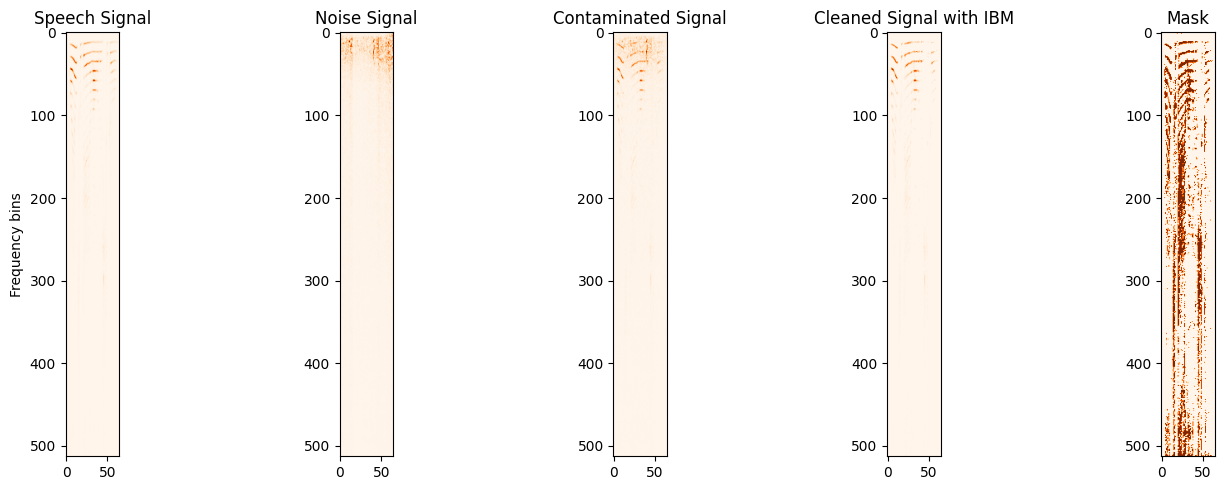

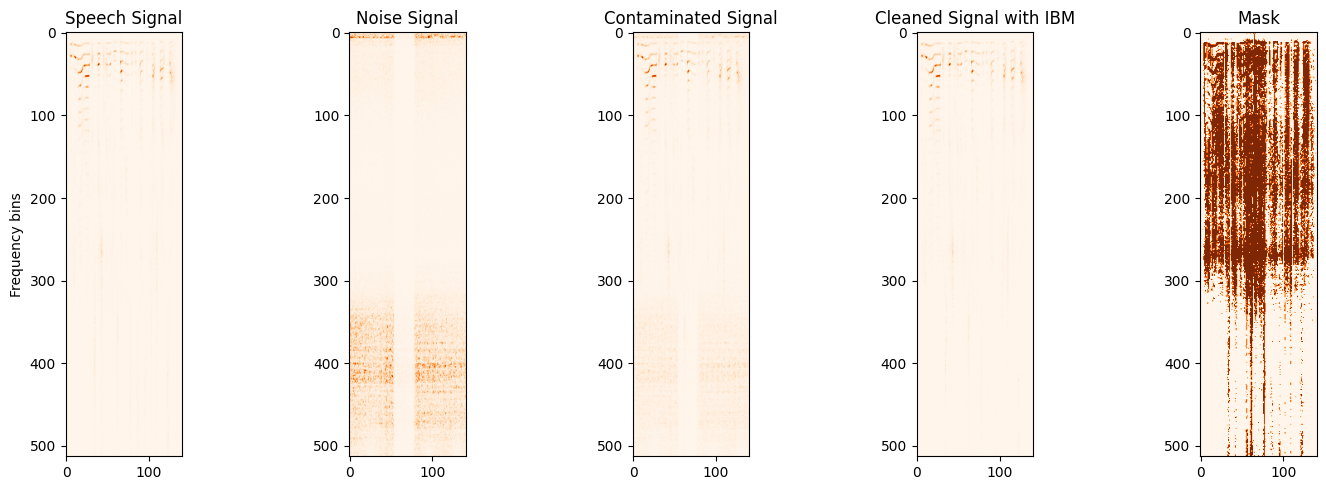

In [10]:
plot_speech_mask(1)
plot_speech_mask(100)

- The cleaned signal with IBM shows how IBM can be used to remove noise and contamination from speech signals, restoring the original clean speech

In [11]:
from keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, x, y, batch_size=10):
        self.x = x
        self.y = y
        self.batch_size = batch_size

    def __len__(self):
        return len(self.x) // self.batch_size

    def __getitem__(self, idx):
        start_idx = idx * self.batch_size
        end_idx = (idx + 1) * self.batch_size

        batch_X = [self.x[i] for i in range(start_idx, end_idx)]
        batch_Y = [self.y[i] for i in range(start_idx, end_idx)]
        return np.array(batch_X), np.array(batch_Y)

In [12]:
#as speeches have variable sequence lengths create datagenerator of 10 (as 10 speeches in sequence have same length)
train_datagen = DataGenerator(x_train,y_train)
val_datagen = DataGenerator(x_val,y_val)

In [ ]:
#define and compile model
speech_denoising = tf.keras.models.Sequential([
                              tf.keras.layers.LSTM(1024,return_sequences=True,input_shape=(None,513)),
                              tf.keras.layers.Dropout(0.2),
                              tf.keras.layers.LSTM(1024,return_sequences=True),
                              tf.keras.layers.Dropout(0.2),
                              tf.keras.layers.Dense(513,activation='sigmoid') ])

speech_denoising.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])

# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)


speech_denoising.summary()

speech_denoising_his = speech_denoising.fit(train_datagen,epochs = 100, validation_data =  val_datagen,callbacks=[early_stopping])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, None, 1024)        6299648   
                                                                 
 dropout_4 (Dropout)         (None, None, 1024)        0         
                                                                 
 lstm_3 (LSTM)               (None, None, 1024)        8392704   
                                                                 
 dropout_5 (Dropout)         (None, None, 1024)        0         
                                                                 
 dense_2 (Dense)             (None, None, 513)         525825    
                                                                 
Total params: 15218177 (58.05 MB)
Trainable params: 15218177 (58.05 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100


In [ ]:
file_name = data_folder+'speech_denoising_p5.h5'
speech_denoising.save_weights(file_name)

#save model history
history_dict = speech_denoising_his.history

# Save it to a JSON file
with open(data_folder+'speech_denoising_rnn_his.json', 'w') as file:
    json.dump(history_dict, file)

In [72]:
#define and compile model
speech_denoising = tf.keras.models.Sequential([
                              tf.keras.layers.LSTM(1024,return_sequences=True,input_shape=(None,513)),
                              tf.keras.layers.Dropout(0.2),
                              tf.keras.layers.LSTM(1024,return_sequences=True),
                              tf.keras.layers.Dropout(0.2),
                              tf.keras.layers.Dense(513,activation='sigmoid') ])

speech_denoising.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])

In [73]:
#load weights and history
file_name = data_folder+'speech_denoising_p5.h5'
speech_denoising.load_weights(file_name)

#load history
with open(data_folder+'speech_denoising_rnn_his.json') as file:
    speech_denoising_his = json.load(file)

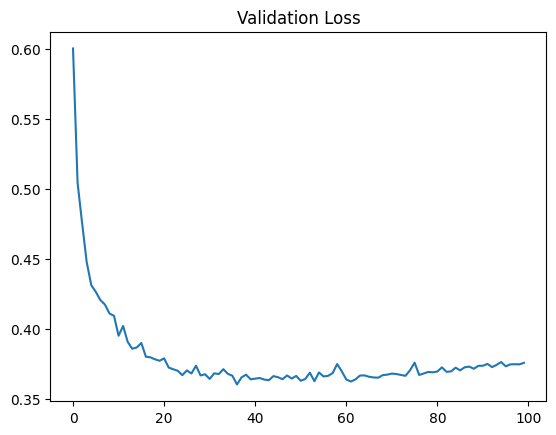

In [74]:
#Plot validation loss
plt.title('Validation Loss')
plt.plot(speech_denoising_his['val_loss'])
plt.show()

In [75]:
#define SNR calculation for a batch of data
def calculate_batch_snr(s_batch, s_hat_batch):
    snr_batch = []
    for s, s_hat in zip(s_batch, s_hat_batch):
        #y true
        y_true = librosa.istft(s, hop_length=512)
        #inverse stft of predicted
        y_predict = librosa.istft(s_hat, hop_length=512)

        #calculate signal
        signal_power = np.sum(y_true**2)

        #calculate noise
        noise_power = np.sum((y_true - y_predict)**2)
        SNR = 10 * np.log10(signal_power / (noise_power + 1e-20)) #add some value to denominator
        snr_batch.append(SNR)
    return snr_batch

In [76]:
#create a list to append snr values
snr_values = []
#iterate through validation data in batches of 10
for batch in range(0,len(x_val),10):
  curr_val_x = np.array(x_val[batch:batch+10])
  #predict IBM
  M_hat = speech_denoising.predict(curr_val_x,verbose=0)
  M_hat = M_hat.transpose(0,2,1)
  #get true sppech
  S_batch = np.array(S_v[batch:batch+10])

  #get validation contaminated speech (complex values)
  curr_batch = np.array(X_v[batch:batch+10])
  S_hat = np.array([x*m for x,m in zip(curr_batch,M_hat)])

  snr_batch = calculate_batch_snr(S_batch,S_hat)
  snr_values.extend(snr_batch)

In [78]:
print(f'Min SNR value on the validation data : {np.min(snr_values):.2f} dB')
print(f'Avg SNR value on the validation data : {np.mean(snr_values):.2f} dB')
print(f'Max SNR value on the validation data : {np.max(snr_values):.2f} dB')

Min SNR value on the validation data : 5.79 dB
Avg SNR value on the validation data : 12.36 dB
Max SNR value on the validation data : 29.28 dB


### Validation SNR
- As expected, achieved an SNR of 12.36 dB on validation data.
- Also, validation loss converged and it kind of started to increase. So, I think current number of iterations are good enough.

In [95]:
#let's visualize some signals from validation data
def plot_val_speech_mask(index):
    # Create subplots for 6 spectrograms
    fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(15, 5))

    ax[0].set(ylabel='Frequency bins')

    # Plot each spectrogram
    ax[0].imshow(np.abs(S_v[index]), cmap='Oranges')
    ax[0].set(title='Speech Signal')

    ax[1].imshow(np.abs(N_v[index]), cmap='Oranges')
    ax[1].set(title='Noise Signal')

    ax[2].imshow(np.abs(X_v[index]), cmap='Oranges')
    ax[2].set(title='Contaminated Signal')

    #predict ibm and Compute cleaned signal as an element-wise multiplication of IBM with X_v
    M_hat = speech_denoising.predict(np.expand_dims(np.abs(X_v[index]).T,axis=0),verbose=0)
    M_hat = np.squeeze(M_hat).T
    cleaned_signal = M_hat * X_v[index]

    ax[3].imshow(np.abs(cleaned_signal), cmap='Oranges')
    ax[3].set(title='Cleaned Signal with predicted IBM')

    ax[4].imshow(M_hat, cmap='Oranges')
    ax[4].set(title='Predicted Mask')

    ax[5].imshow(ibm_v[index], cmap='Oranges')
    ax[5].set(title='Ideal Mask')

    plt.tight_layout()
    plt.show()


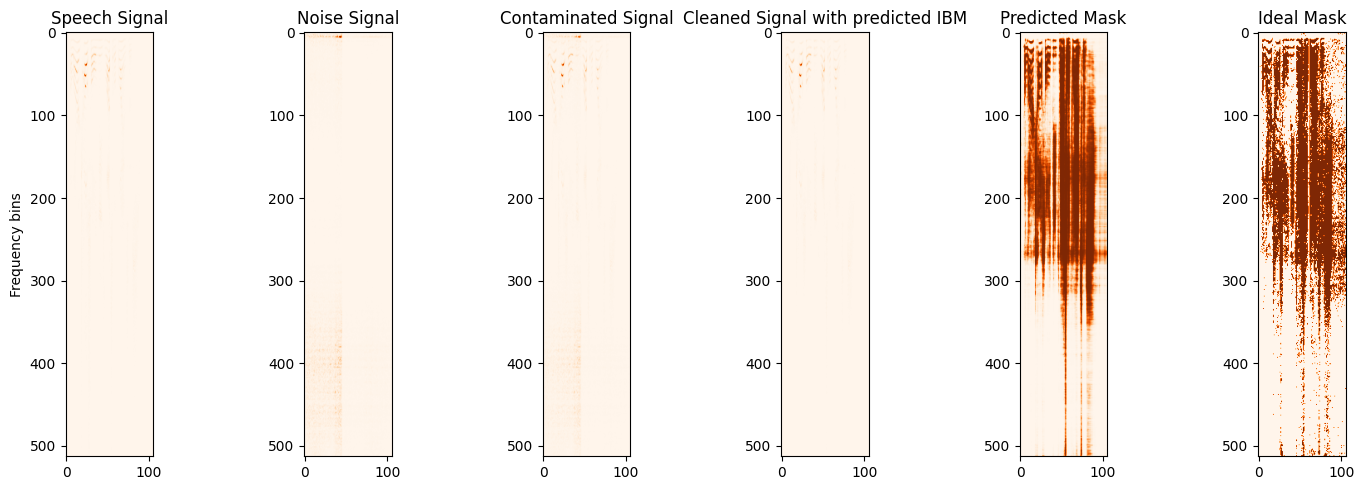

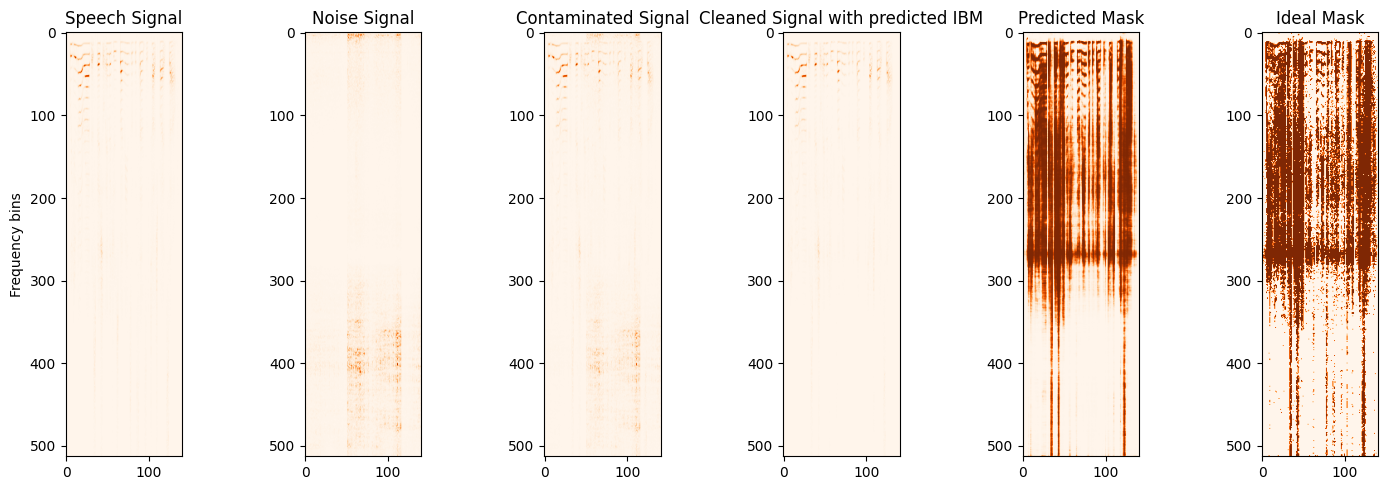

In [96]:
plot_val_speech_mask(200)
plot_val_speech_mask(100)

- We can see that model learned good enough to predict binary masks

In [81]:
def recover_clean_speech(c_signal):

  #reshape, take abs and predict
  M_hat = speech_denoising.predict(np.expand_dims(np.abs(c_signal).T,axis=0),verbose=0)
  M_hat = np.squeeze(M_hat).T

  #return recovered speech
  recovered_speech = c_signal*M_hat

  #inverse stft
  recovered_speech = librosa.istft(recovered_speech,hop_length=512)

  return recovered_speech

In [82]:
#display audio for validation sample
sample_val = X_v[90]
clean_speech = S_v[90]

contaminated = librosa.istft(sample_val,hop_length=512)
clean = librosa.istft(clean_speech,hop_length=512)
recovered_speech = recover_clean_speech(sample_val)

print('Contaminated Speech:')
display(Audio(contaminated,rate=16000))

print('\nRecovered Speech using model:')
display(Audio(recovered_speech,rate=16000))

print('\nClean Speech(Ground Truth):')
display(Audio(clean,rate=16000))

Contaminated Speech:



Recovered Speech using model:



Clean Speech(Ground Truth):


- Working like a charm 😀. Let's denoise test files and save them.

In [83]:
test_folder = data_folder+'timit-homework/te'
test_recovered_folder = data_folder+'timit-homework/te_recover/'

test_list = os.listdir(test_folder)
test_list.sort()

for file in test_list:
    file_path = os.path.join(test_folder,file)
    audio,sr = librosa.load(file_path,sr=None)
    spectogram = librosa.stft(audio,n_fft=1024,hop_length=512)

    recovered_speech = recover_clean_speech(spectogram)

    #write files
    file_name = file.replace('x','s')
    filename = os.path.join(test_recovered_folder,file_name)
    sf.write(filename, recovered_speech, sr)

In [94]:
#randomly select 2 files
random_test = [np.random.choice(test_list) for _ in range(2)]

for file in random_test:
    file_path = os.path.join(test_folder,file)
    audio,sr = librosa.load(file_path,sr=None)
    spectogram = librosa.stft(audio,n_fft=1024,hop_length=512)

    recovered_speech = recover_clean_speech(spectogram)

    #display files
    print(f'\nFilename: {file}')
    print('Test contaminated speech:')
    display(Audio(audio,rate=sr))
    print('\nTest recovered speech:')
    display(Audio(recovered_speech,rate=sr))


Filename: tex0028.wav
Test contaminated speech:



Test recovered speech:



Filename: tex0322.wav
Test contaminated speech:



Test recovered speech:


- Yay! Working like a charm even on test data.😀